<a href="https://colab.research.google.com/github/EkansTCG/AI-Final/blob/main/Data_Preprocessing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# ===============================================
# Clean → Encode → Classify (KNN) — Simplified
# ===============================================
# Dataset: Kaggle "Mushroom Classification"
# Expected file: ./mushrooms.csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer  # used ONCE as an example
from sklearn.neighbors import KNeighborsClassifier
import numpy as np # Make sure numpy is imported

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [17]:
# -----------------------------
# 0) Load data
# -----------------------------
csv_path = "mushrooms.csv"   # TODO: place the file or change path
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path} — download from Kaggle and try again.")

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
# TODO: Get the top 5 rows (1 line of code)
df.head()


Initial shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [18]:
# -----------------------------
# 1) Basic cleaning (duplicates, empty rows)
# -----------------------------
before = df.shape[0]

# TODO: Remove duplicates (1 line of code)
df.drop_duplicates(inplace=True)

print("Removed duplicates:", before - df.shape[0])


before = df.shape[0]
# TODO: Drop fully empty rows (1 line of code)
df.dropna(how="all", inplace=True)

print("Dropped fully empty rows:", before - df.shape[0])

print("\nMissing values per column (top 10):")
# TODO: Display the missing values per column (1 line of code)
print(df.isna().sum().sort_values(ascending=False).head(10))



Removed duplicates: 0
Dropped fully empty rows: 0

Missing values per column (top 10):
class              0
cap-shape          0
cap-surface        0
cap-color          0
bruises            0
odor               0
gill-attachment    0
gill-spacing       0
gill-size          0
gill-color         0
dtype: int64


In [19]:
# -----------------------------
# 2) Target & split
# -----------------------------
TARGET_COL = "class"  # TODO: change if your label column differs
if TARGET_COL not in df.columns:
    raise ValueError("Update TARGET_COL to match your dataset's label column.")

# TODO: Drop the target column from the "X" (1 line of code)
X = df.drop(columns=[TARGET_COL])

# TODO: Set up the target column (1 line of code)
y=df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Detect types BEFORE imputation/encoding
orig_numeric_cols = X_train.select_dtypes(include='number').columns.tolist() # TODO: Extract the numeric columns from the training data set and store it as a list
orig_categorical_cols = orig_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist() # TODO: Extract the categorical columns from the training data set and store it as a list
print("Original numeric cols:", orig_numeric_cols if orig_numeric_cols else "None")
print("Original categorical cols (sample):", orig_categorical_cols[:10])


Train/Test shapes: (6499, 22) (1625, 22)
Original numeric cols: None
Original categorical cols (sample): ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape']


In [20]:
# --------------------------------------------
# 3) IMPUTATION (MANUAL) + one sklearn example
# --------------------------------------------
# Manual imputation rules:
#  - Numeric: fill with TRAIN median
#  - Categorical: fill with TRAIN mode
# NOTE: We compute imputation values on TRAIN only, then apply to both TRAIN & TEST.

X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

# a) Numeric → manual median
# For each of the numeric columns, fill the empty values with the median of the train column.
for col in orig_numeric_cols:
    median_val = X_train_imp[col].median()
    X_train_imp[col].fillna(median_val, inplace=True)
    X_test_imp[col].fillna(median_val, inplace=True)


# b) Categorical → manual mode
# For each of the categorical columns, fill the empty values with the mode of the train column.
for col in orig_categorical_cols:
    # .mode() can return multiple values if there's a tie, so we take the first one with [0].
    mode_val = X_train_imp[col].mode()[0]
    X_train_imp[col].fillna(mode_val, inplace=True)
    X_test_imp[col].fillna(mode_val, inplace=True)


# c) One EXAMPLE using sklearn SimpleImputer on a SINGLE column (categorical)
# Choose a categorical column present in your dataset:
IMPUTE_EXAMPLE_COL = "odor"  # TODO: change if needed

if IMPUTE_EXAMPLE_COL in X_train_imp.columns:
    cat_imp = SimpleImputer(strategy="most_frequent")

    # Fit and transform the train data, then assign it back
    imputed_train_col = cat_imp.fit_transform(X_train_imp[[IMPUTE_EXAMPLE_COL]])
    X_train_imp[IMPUTE_EXAMPLE_COL] = imputed_train_col.ravel()

    # Transform the test data using the fitted imputer, then assign it back
    imputed_test_col = cat_imp.transform(X_test_imp[[IMPUTE_EXAMPLE_COL]])
    X_test_imp[IMPUTE_EXAMPLE_COL]  = imputed_test_col.ravel()

    print(f"\nUsed sklearn SimpleImputer on column: {IMPUTE_EXAMPLE_COL}")
else:
    print(f"\n[Note] Example imputer column '{IMPUTE_EXAMPLE_COL}' not found. Skipping sklearn example.")


Used sklearn SimpleImputer on column: odor


/tmp/ipython-input-3920457936.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_imp[col].fillna(mode_val, inplace=True)
/tmp/ipython-input-3920457936.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [21]:
# --------------------------------------------
# 4) ENCODING
#    - EXPLICIT One-Hot Encoding on ONE chosen column
#    - Then get_dummies for the remaining categoricals
# --------------------------------------------
# Choose the column for explicit OHE:
EXPLICIT_OHE_COL = "odor"  # TODO: change if needed

X_train_enc = X_train_imp.copy()
X_test_enc  = X_test_imp.copy()

if EXPLICIT_OHE_COL in X_train_enc.columns:
    # EXPLICIT OHE on this ONE column — fit on TRAIN only and TEST only separately (2 lines of code)
    train_ohe = pd.get_dummies(X_train_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)
    test_ohe = pd.get_dummies(X_test_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)

    # Align test columns to train (avoid unseen-category issues)
    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

    # Drop original column and concat OHE columns
    X_train_enc = pd.concat([X_train_enc.drop(columns=[EXPLICIT_OHE_COL]), train_ohe], axis=1)
    X_test_enc  = pd.concat([X_test_enc.drop(columns=[EXPLICIT_OHE_COL]),  test_ohe], axis=1)

    print(f"\nExplicit OHE applied to column: {EXPLICIT_OHE_COL}")
else:
    print(f"\n[Note] Explicit OHE column '{EXPLICIT_OHE_COL}' not found. Skipping explicit OHE step.")

# TODO: Identify remaining categorical columns (post explicit OHE drop) in the TRAINING data set only (1 line of code)
remaining_categorical_cols = X_train_enc.select_dtypes(include=['object', 'category']).columns.tolist()

# TODO: Apply get_dummies to the remaining categoricals (fit on TRAIN, align TEST) (1 lines of code)
X_train_enc = pd.get_dummies(X_train_enc, columns=remaining_categorical_cols)
X_test_enc = pd.get_dummies(X_test_enc, columns=remaining_categorical_cols)

# Align test columns to train columns (VERY IMPORTANT)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)


Explicit OHE applied to column: odor
Encoded train shape: (6499, 117)
Encoded test shape: (1625, 117)


In [ ]:
# --------------------------------------------
# 5) NORMALIZE numeric columns (if any)
#    (Scale ONLY the original numeric columns; don't scale one-hot columns)
# --------------------------------------------
# TODO: Use the Standard Scaler to scale the numeric values (1 line of code)
scaler = StandardScaler()
# Identify the numeric columns that are present in the encoded DataFrame
numeric_cols_to_scale = [c for c in orig_numeric_cols if c in X_train_enc.columns]

# Check if there are any numeric columns to scale
if numeric_cols_to_scale:
    # 1. Fit the scaler ONLY on the training data's numeric columns
    scaler.fit(X_train_enc[numeric_cols_to_scale])

    # 2. Transform the numeric columns in BOTH the train and test sets
    X_train_enc[numeric_cols_to_scale] = scaler.transform(X_train_enc[numeric_cols_to_scale])
    X_test_enc[numeric_cols_to_scale] = scaler.transform(X_test_enc[numeric_cols_to_scale])

    # 3. Print the names of the columns that were scaled
    print("Columns scaled:")
    print(numeric_cols_to_scale)
else:
    print("No numeric columns to scale.")

# TODO: Fit the scaler and scale the train and test data separately. (3 lines of code)
# TODO: Print the names of the columns scaled if any (4 lines of code at max)

No numeric columns to scale.


In [25]:
# --------------------------------------------
# 6) KNN + Grid Search
# --------------------------------------------

# --- SPEEDUP FIX: Create a smaller sample for the grid search ---
# Use a fraction of the data (e.g., 20%) for a much faster search.
# Change 'frac' if it's still too slow or you want to use more data.
sample_frac = 0.2
sample_size = int(len(X_train_enc) * sample_frac)
sample_indices = np.random.choice(X_train_enc.index, size=sample_size, replace=False)

X_train_sample = X_train_enc.loc[sample_indices]
y_train_sample = y_train.loc[sample_indices]

print(f"Original training data size: {len(X_train_enc)}")
print(f"Running GridSearchCV on a sample of size: {len(X_train_sample)}\n")
# ----------------------------------------------------------------

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}

# Run the grid search on the SMALLER sample of data
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_sample, y_train_sample)

# Now, get the best estimator and train it on the FULL training data
best_knn = grid.best_estimator_
best_knn.fit(X_train_enc, y_train) # Optional but good practice

print("Best parameters found:", grid.best_params_)
print("Best estimator:", best_knn)
# You can now use 'best_knn' to make predictions on your test set

Original training data size: 6499
Running GridSearchCV on a sample of size: 1299

Best parameters found: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)



Test accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



<Figure size 640x480 with 0 Axes>

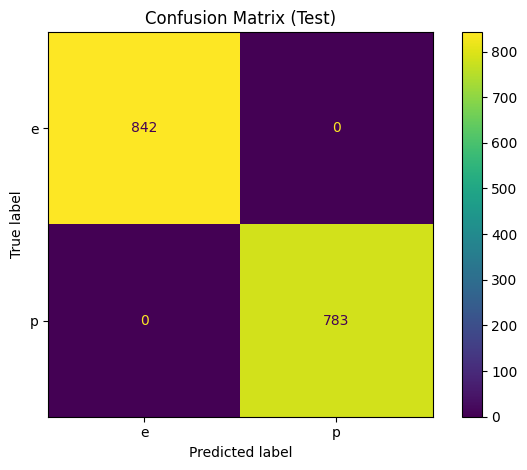

In [26]:
# --------------------------------------------
# 7) Evaluate on held-out TEST
# --------------------------------------------
# TODO: Use KNN to make predictions on the test dataset (1 line of code)

y_pred = best_knn.predict(X_test_enc)

test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(test_acc))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

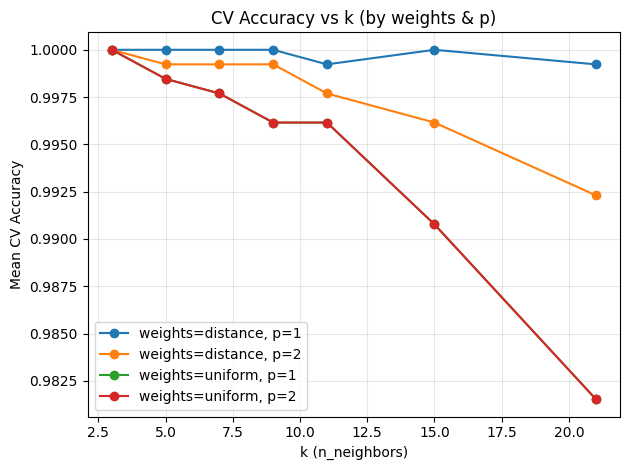

In [27]:
# --------------------------------------------
# 8) Validation curve (CV accuracy vs k)
# --------------------------------------------
cvres = pd.DataFrame(grid.cv_results_)
plotdf = cvres[["param_n_neighbors", "param_weights", "param_p", "mean_test_score"]].rename(
    columns={"param_n_neighbors":"k", "param_weights":"weights", "param_p":"p"}
)

plt.figure()
for (w, pval), sub in plotdf.groupby(["weights", "p"]):
    sub = sub.sort_values("k")
    plt.plot(sub["k"], sub["mean_test_score"], marker="o", label=f"weights={w}, p={pval}")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs k (by weights & p)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

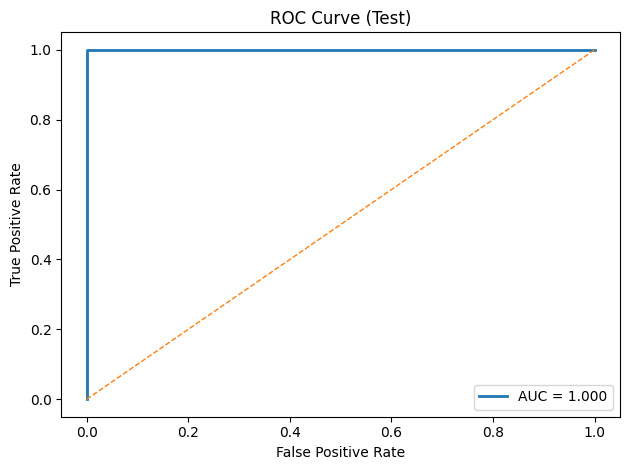

In [29]:
# --------------------------------------------
# 9) ROC curve (binary; micro-average if multiclass)
# --------------------------------------------
# Make sure best_knn is defined if this cell is run independently
if 'best_knn' not in locals():
    print("Variable 'best_knn' not found. Please run the previous cell first.")
else:
    if hasattr(best_knn, "predict_proba"):
        classes_ = np.unique(y_train)
        y_test_enc_int = pd.Categorical(y_test, categories=classes_).codes
        proba = best_knn.predict_proba(X_test_enc)

        if len(classes_) == 2:
            fpr, tpr, _ = roc_curve(y_test_enc_int, proba[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
            plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (Test)")
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
        else:
            y_bin = label_binarize(y_test_enc_int, classes=range(len(classes_)))
            fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, lw=2, label=f"Micro-average AUC = {roc_auc:.3f}")
            plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (Micro-average)")
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()

In [31]:
# --------------------------------------------
# 10) Print summary of features
# Sample Output: Final feature count: 25
# Best KNN: KNeighborsClassifier(n_neighbors=7, p=2, weights='distance')
# --------------------------------------------
# TODO: Print the final stats (2 lines of code)
print("Final feature count:", X_train_enc.shape[1])
print("Best KNN:", best_knn)
print("Test Accuracy:", test_acc)
print("Best Parameters:", grid.best_params_)

Final feature count: 117
Best KNN: KNeighborsClassifier(n_neighbors=3, p=1)
Test Accuracy: 1.0
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
